# Project: Protein stability prediction

In the project you will try to predict protein stability changes upon point mutations. 
We will use acuumulated data from experimental databases, i.e. the Megascale dataset. A current [paper](https://www.pnas.org/doi/10.1073/pnas.2314853121) has already preprocessed the dataset and created homology reduced data splits. We will reuse these.

The downloaded data includes measurements of changes in the Gibbs free enrgy ($\Delta \Delta G $). 
This will be the value that you will have to predict for a given protein with a point mutation. 

Here we will use protein embeddings computed by ESM as input. 
We provide precomputed embeddings from the last layer of the smallest ESM model. You can adjust the Dataloader's code to load the embedding of the wild type or of the mutated sequence or both. You can use it however you like. This is just to provide you easy access to embeddings. If you want to compute your own embeddings from other layers or models you can do that, too. 

Below we provide you with a strcuture for the project that you can start with.  
Edit the cells to your liking and add more code to create your final model.


## Imports

In [1]:
import os 
import numpy as np
import pandas as pd
import scipy
import sklearn.metrics as skmetrics

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import lightning as L

import torchmetrics
from torchmetrics.regression import PearsonCorrCoef

## Dataloading

We are using the Megascale dataset. The train, validation and test sets are already predefined.  
As mentioned, we provide embeddings from the last layer of ESM as input. You can access either the wild type or the mutated sequence and you could also further adjsut the embeddings. 
Here we have an embedding representing the complete sequence. It was computed by averaging over the embeddings per residue in the sequence. 

The ``Dataset`` classes return tuples of ``(embedding, ddg_value)``.

In [9]:
class ProtEmbeddingDataset(Dataset):
    """
    Dataset that returns (mut_embedding, wt_embedding, ddG_label).
    WT embedding is required; raises an error if missing.
    """
    def __init__(self, tensor_folder, csv_file, id_col="name", label_col="ddG_ML", layer=6):
        self.tensor_folder = tensor_folder
        self.layer = layer

        self.df = pd.read_csv(csv_file, sep=",")
        self.df = self.df[self.df.mut_type != "wt"].reset_index(drop=True)

        self.labels = torch.tensor(self.df[label_col].values, dtype=torch.float32)
        self.ids = self.df[id_col].values
        self.wt_names = self.df["WT_name"].values

    def __len__(self):
        return len(self.labels)

    def _load_emb(self, name: str, suffix: str | None = None):
        fname = f"{name}{suffix if suffix else ''}.pt"
        path = os.path.join(self.tensor_folder, fname)
        obj = torch.load(path, map_location="cpu")
        return obj["mean_representations"][self.layer].float()

    def __getitem__(self, idx):
        # mutant embedding (must exist)
        emb_mut = self._load_emb(self.ids[idx], suffix=None)

        # wildtype embedding: must exist with one of the suffixes
        wt_base = self.wt_names[idx]
        wt_path1 = os.path.join(self.tensor_folder, wt_base + "_wte.pt")
        wt_path2 = os.path.join(self.tensor_folder, wt_base + "_wty.pt")

        if os.path.exists(wt_path1):
            emb_wt = self._load_emb(wt_base, suffix="_wte")
        elif os.path.exists(wt_path2):
            emb_wt = self._load_emb(wt_base, suffix="_wty")
        else:
            raise FileNotFoundError(
                f"WT embedding missing for WT_name='{wt_base}' "
                f"(tried '{wt_base}_wte.pt' and '{wt_base}_wty.pt')"
            )

        label = self.labels[idx]
        return emb_mut, emb_wt, label

In [10]:
# usage 
# make sure to adjust the paths to where your files are located
dataset_train = ProtEmbeddingDataset('project_data/mega_train_embeddings', 'project_data/mega_train.csv')
dataset_val = ProtEmbeddingDataset('project_data/mega_val_embeddings', 'project_data/mega_val.csv')
# dataset_test = ProtEmbeddingDataset('project_data/mega_test_embeddings', 'project_data/mega_test.csv') # only once available

dataloader_train = DataLoader(dataset_train, batch_size=1024, shuffle=True, num_workers=16)
dataloader_val = DataLoader(dataset_val, batch_size=512, shuffle=False, num_workers=16)
# dataloader_test = DataLoader(dataset_test, batch_size=32, shuffle=False)

/Users/jianzhouyao/Library/Mobile Documents/com~apple~CloudDocs/Universität/ETH/DL in Biology/Dry_Lab/bc_deep_learning_in_biology/venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:424: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 10 (`cpuset` is not taken into account), which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  self.check_worker_number_rationality()


## Data exploration

Explore the data and try to understand what we are working with. How is the data structured? How is it distributed? What do the values mean? How is the data represented and how else could it be represented? 
Your approach depends on your understanding of the data.

In [4]:
# ── 1. Basic dataset statistics ───────────────────────────────────────────────
df_train = pd.read_csv('project_data/mega_train.csv')
df_val   = pd.read_csv('project_data/mega_val.csv')

# filter to mutations only (exclude wild-type rows)
df_train_mut = df_train[df_train.mut_type != "wt"]
df_val_mut   = df_val[df_val.mut_type != "wt"]

print("=== Dataset sizes ===")
print(f"Train mutations : {len(df_train_mut):,}")
print(f"Val   mutations : {len(df_val_mut):,}")
print(f"Train proteins  : {df_train_mut['WT_name'].nunique():,}")
print(f"Val   proteins  : {df_val_mut['WT_name'].nunique():,}")
print()

print("=== ddG_ML summary (train) ===")
print(df_train_mut["ddG_ML"].describe().round(3))

=== Dataset sizes ===
Train mutations : 215,731
Val   mutations : 27,328
Train proteins  : 239
Val   proteins  : 31

=== ddG_ML summary (train) ===
count    215731.000
mean         -0.743
std           1.002
min          -5.663
25%          -1.257
50%          -0.497
75%          -0.040
max           3.099
Name: ddG_ML, dtype: float64


In [5]:
print("Shape:", df_train_mut.shape)
print("\nColumns:", df_train.columns.tolist())  # <- this is df_train, not df_train_mut
print("\n--- First few rows ---")
df_train_mut.head(10)

Shape: (215731, 7)

Columns: ['Unnamed: 0', 'name', 'ddG_ML', 'mut_type', 'WT_name', 'aa_seq', 'wt_seq']

--- First few rows ---


,Unnamed: 0,name,ddG_ML,mut_type,WT_name,aa_seq,wt_seq
5,5,r10_437_TrROS_Hall.pdb_E1Q,0.294920,E1Q,r10_437_TrROS_Hall.pdb,QPELVFKVRVRTKDGRELEIEVSAEDLEKLLEALPDIEEVEIEEVEP,EPELVFKVRVRTKDGRELEIEVSAEDLEKLLEALPDIEEVEIEEVEP
6,6,r10_437_TrROS_Hall.pdb_E1N,0.356107,E1N,r10_437_TrROS_Hall.pdb,NPELVFKVRVRTKDGRELEIEVSAEDLEKLLEALPDIEEVEIEEVEP,EPELVFKVRVRTKDGRELEIEVSAEDLEKLLEALPDIEEVEIEEVEP
7,7,r10_437_TrROS_Hall.pdb_E1H,0.264306,E1H,r10_437_TrROS_Hall.pdb,HPELVFKVRVRTKDGRELEIEVSAEDLEKLLEALPDIEEVEIEEVEP,EPELVFKVRVRTKDGRELEIEVSAEDLEKLLEALPDIEEVEIEEVEP
8,8,r10_437_TrROS_Hall.pdb_E1D,0.174492,E1D,r10_437_TrROS_Hall.pdb,DPELVFKVRVRTKDGRELEIEVSAEDLEKLLEALPDIEEVEIEEVEP,EPELVFKVRVRTKDGRELEIEVSAEDLEKLLEALPDIEEVEIEEVEP
9,9,r10_437_TrROS_Hall.pdb_E1R,0.531557,E1R,r10_437_TrROS_Hall.pdb,RPELVFKVRVRTKDGRELEIEVSAEDLEKLLEALPDIEEVEIEEVEP,EPELVFKVRVRTKDGRELEIEVSAEDLEKLLEALPDIEEVEIEEVEP
10,10,r10_437_TrROS_Hall.pdb_E1K,0.540126,E1K,r10_437_TrROS_Hall.pdb,KPELVFKVRVRTKDGRELEIEVSAEDLEKLLEALPDIEEVEIEEVEP,EPELVFKVRVRTKDGRELEIEVSAEDLEKLLEALPDIEEVEIEEVEP
11,11,r10_437_TrROS_Hall.pdb_E1T,0.177664,E1T,r10_437_TrROS_Hall.pdb,TPELVFKVRVRTKDGRELEIEVSAEDLEKLLEALPDIEEVEIEEVEP,EPELVFKVRVRTKDGRELEIEVSAEDLEKLLEALPDIEEVEIEEVEP
12,12,r10_437_TrROS_Hall.pdb_E1S,0.296494,E1S,r10_437_TrROS_Hall.pdb,SPELVFKVRVRTKDGRELEIEVSAEDLEKLLEALPDIEEVEIEEVEP,EPELVFKVRVRTKDGRELEIEVSAEDLEKLLEALPDIEEVEIEEVEP
13,13,r10_437_TrROS_Hall.pdb_E1A,0.189209,E1A,r10_437_TrROS_Hall.pdb,APELVFKVRVRTKDGRELEIEVSAEDLEKLLEALPDIEEVEIEEVEP,EPELVFKVRVRTKDGRELEIEVSAEDLEKLLEALPDIEEVEIEEVEP
14,14,r10_437_TrROS_Hall.pdb_E1G,0.255998,E1G,r10_437_TrROS_Hall.pdb,GPELVFKVRVRTKDGRELEIEVSAEDLEKLLEALPDIEEVEIEEVEP,EPELVFKVRVRTKDGRELEIEVSAEDLEKLLEALPDIEEVEIEEVEP


In [6]:
# 3. What does mut_type look like?
print("Example mut_type values:")
print(df_train[df_train.mut_type != "wt"]["mut_type"].head(10).tolist())
# expect something like: ['A42G', 'K7R', 'L15A', ...]
# format is: [wild-type AA][position][mutant AA]

Example mut_type values:
['E1Q', 'E1N', 'E1H', 'E1D', 'E1R', 'E1K', 'E1T', 'E1S', 'E1A', 'E1G']


## Model architecture and training

Now it's your turn. Create a model trained on the embeddings and the corresponding ddG values.  
Be aware that this is not a classification task, but a regression task. You want to predict a continuous number that is as close to the measured $\Delta \Delta G $ value as possible.
You will need to adjust your architecture and loss accordingly.

Train the model with the predefined dataloaders. And try to improve the model. 
Only test on the test set at the very end, when you have finished fine-tuning you model. 

## Why linear regression first?

- Zero hidden layers → fully explainable: each of the 320 embedding dimensions 
  gets a single weight, directly telling you how much it contributes to ΔΔG
- If it already beats BLOSUM (Pearson ~0.2), the ESM embeddings carry real signal
- Sets a performance floor for the MLP to beat
- Fast to train — no GPU needed

In [11]:
# ── Linear Regression on mutant + wildtype embeddings ─────────────────────────
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler

# ── 1. Reinstantiate datasets (picks up the updated __getitem__ returning 3 values) ──
dataset_train = ProtEmbeddingDataset('project_data/mega_train_embeddings', 'project_data/mega_train.csv')
dataset_val   = ProtEmbeddingDataset('project_data/mega_val_embeddings',   'project_data/mega_val.csv')

dataloader_train = DataLoader(dataset_train, batch_size=1024, shuffle=True,  num_workers=0)
dataloader_val   = DataLoader(dataset_val,   batch_size=512,  shuffle=False, num_workers=0)

# ── 2. Extract all embeddings and labels from dataloaders ─────────────────────
def extract_embeddings(dataloader):
    X, Y = [], []
    for emb_mut, emb_wt, label in dataloader:
        combined = torch.cat([emb_mut, emb_wt], dim=-1)  # (batch, 1536)
        X.append(combined.numpy())
        Y.append(label.numpy())
    return np.concatenate(X), np.concatenate(Y)

print("Extracting train embeddings...")
X_train, y_train = extract_embeddings(dataloader_train)
print("Extracting val embeddings...")
X_val, y_val = extract_embeddings(dataloader_val)

print(f"X_train shape: {X_train.shape}")  # (215731, 1536)
print(f"y_train shape: {y_train.shape}")  # (215731,)

Extracting train embeddings...
Extracting val embeddings...
X_train shape: (215731, 1536)
y_train shape: (215731,)


In [12]:
# ── 2. Train Ridge regression (L2 regularized linear model) ───────────────────
# Ridge is more stable than plain LinearRegression for high-dimensional inputs

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)

model_lr = Ridge(alpha=1.0)
model_lr.fit(X_train_scaled, y_train)

preds_lr = model_lr.predict(X_val_scaled)

RMSE    : 1.1183
Pearson : 0.3741
Spearman: 0.3354


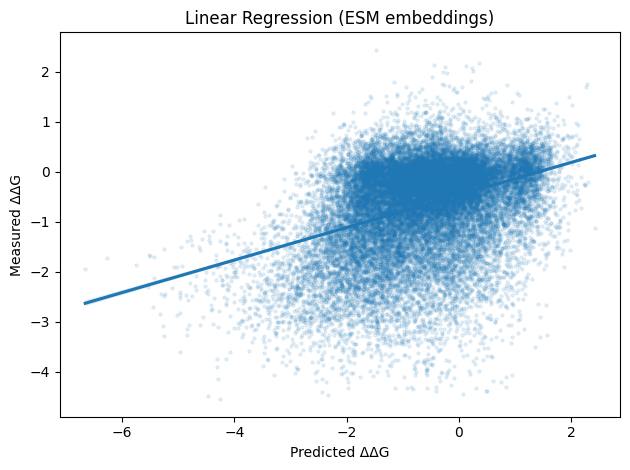

In [13]:
# ── 3. Evaluate ────────────────────────────────────────────────────────────────
rmse_lr = np.sqrt(skmetrics.mean_squared_error(y_val, preds_lr))
print(f"RMSE    : {rmse_lr:.4f}")
print(f"Pearson : {scipy.stats.pearsonr(preds_lr, y_val)[0]:.4f}")
print(f"Spearman: {scipy.stats.spearmanr(preds_lr, y_val)[0]:.4f}")

sns.regplot(x=preds_lr, y=y_val, scatter_kws={"alpha": 0.1, "s": 5})
plt.xlabel("Predicted ΔΔG")
plt.ylabel("Measured ΔΔG")
plt.title("Linear Regression (ESM embeddings)")
plt.tight_layout()
plt.show()

<mark>Incorporating the wildtype sequences in addition to the mutant sequences only marginally improved the metrics.</mark>

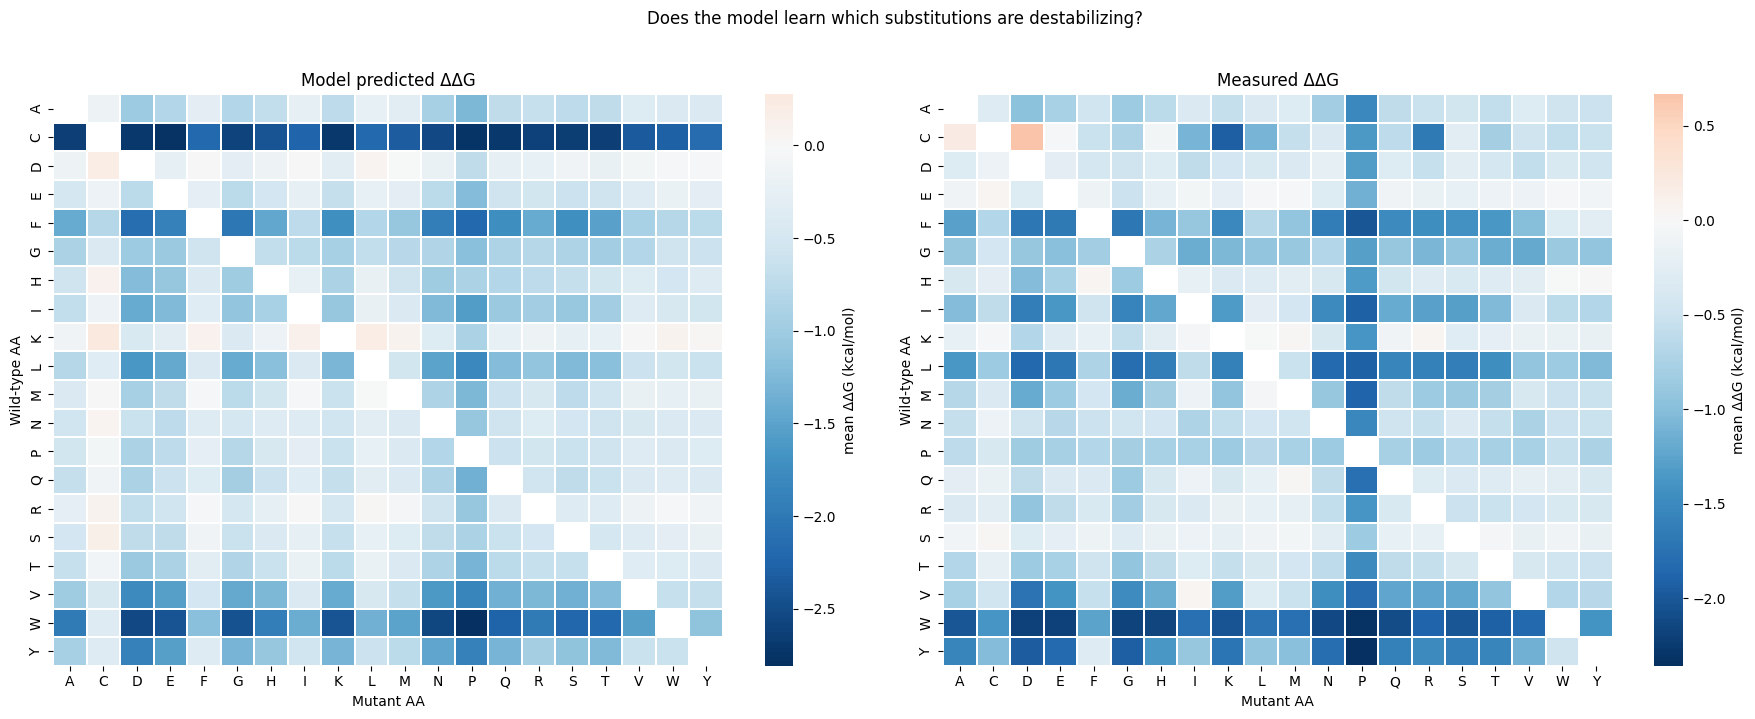

In [14]:
# ── Option A: Mean predicted ΔΔG per substitution type ────────────────────────
# Parse wt and mutant AA from the val dataframe
df_val_mut = pd.read_csv('project_data/mega_val.csv')
df_val_mut = df_val_mut[df_val_mut.mut_type != "wt"].copy()
df_val_mut["wt_aa"]  = df_val_mut["mut_type"].str[0]
df_val_mut["mut_aa"] = df_val_mut["mut_type"].str[-1]
df_val_mut["pred_ddG"] = preds_lr  # predictions from Ridge model

# heatmap: mean predicted ΔΔG for each wt→mut substitution
pivot_pred = df_val_mut.groupby(["wt_aa", "mut_aa"])["pred_ddG"].mean().unstack()
pivot_true = df_val_mut.groupby(["wt_aa", "mut_aa"])["ddG_ML"].mean().unstack()

fig, axes = plt.subplots(1, 2, figsize=(18, 7))
for ax, pivot, title in zip(axes,
                             [pivot_pred, pivot_true],
                             ["Model predicted ΔΔG", "Measured ΔΔG"]):
    sns.heatmap(pivot, cmap="RdBu_r", center=0, ax=ax,
                linewidths=0.3, cbar_kws={"label": "mean ΔΔG (kcal/mol)"})
    ax.set_title(title)
    ax.set_xlabel("Mutant AA")
    ax.set_ylabel("Wild-type AA")

plt.suptitle("Does the model learn which substitutions are destabilizing?", y=1.02)
plt.tight_layout()
plt.show()

## Heatmap Interpretation: Does the model learn biochemistry?

> **Sign convention:** negative ΔΔG = destabilizing, positive ΔΔG = stabilizing.
> Dark blue = destabilizing, pink/red = stabilizing.

> The authors switched the signs when creating the dataset!

### What the model gets right
- **C (Cysteine) row** — correctly predicts that mutating away from Cys is strongly
  destabilizing (dark blue). Cys often forms disulfide bonds critical for structural
  stability; replacing it with almost any other amino acid breaks this bond.
- **W and Y rows** — model correctly learns that mutating away from large aromatic
  residues (Trp, Tyr) is destabilizing. These residues often occupy buried hydrophobic
  cores and contribute strongly to folding stability.
- **General sign** — both heatmaps are predominantly blue (negative ΔΔG), meaning the
  model correctly learns the dataset-wide bias: most random mutations are destabilizing,
  consistent with the well-established biological principle that proteins are already
  near-optimally evolved.

### Where the model falls short
- **Smoothness** — the predicted heatmap is far more uniform than the measured one.
  The model regresses toward the mean, missing sharp per-substitution effects
  (e.g. the strong column-specific patterns visible in the measured heatmap).
- **Missing column structure** — the measured heatmap shows clear *mutant AA* effects
  (e.g. mutating *to* **P/proline** is consistently destabilizing across all wt AAs,
  visible as a dark blue column). This makes biological sense — proline is a helix
  breaker that introduces rigidity. The linear model does not capture this.

### Conclusion
The linear model has learned a **global average effect per wild-type AA** but lacks
the resolution to capture position- or mutant-specific biochemistry. This motivates
moving to a nonlinear model (MLP) that can learn more complex substitution interactions.

## Validation and visualization

To get a good feeling of how the model is performing and to compare with literature, compute the Pearson and Spearman correlations.
You can also plot the predictions in a scatterplot. We have added some code for that. 

In [15]:
preds = []
all_y = []
for batch in dataloader_val:
    x_mut, x_wt, y = batch
    x = torch.cat([x_mut, x_wt], dim=-1)  # (batch, 1536)
    y_hat = model(x)
    preds.append(y_hat.squeeze().detach().numpy())
    all_y.append(y.detach().numpy())

preds = np.concatenate(preds)
all_y = np.concatenate(all_y)

sns.regplot(x=preds, y=all_y)
plt.xlabel("Predicted ddG")
plt.ylabel("Measured ddG")

print("RMSE:", skmetrics.mean_squared_error(all_y, preds, squared="False"))
print("Pearson r:", scipy.stats.pearsonr(preds, all_y))
print("Spearman r:", scipy.stats.spearmanr(preds, all_y))

NameError: name 'model' is not defined

## Interpretation

Try to analyse and interpret your model and/or predictions in the context of the biological question.

## Performance on the test set

At the very end, after choosing your best model, see how well it performs on the test set.